In [10]:
# Read a yaml file of reactions
# Analyze using the non-uniform weighting procedure only
# This version also propagates exptl uncertainties using
#   uncorrelated Monte Carlo
import yaml, sys, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, '../../karlib')
import chem_subs as chem
import multirx_subs as mrx

In [11]:
x = mrx.read_yaml('reactions_dioxolane.yml')
target = x['target']
# coefficients are negative for reactants and positive for products
rxns = x['reactions']

In [12]:
print(f'{len(rxns)} reactions for {target}')
moldata, Geom = mrx.read_educt_data(rxns)
oklist = mrx.check_reactions_balance(rxns, Geom)

15 reactions for dioxolane


In [13]:
T = 0.  # temperature; choose 0 or 298 (meaning 298.15)
exptl = mrx.select_expt(moldata, T)
eq6sum, uexp = mrx.eq6_sums(rxns, target, exptl)

In [14]:
# get theoretical energies for molecules
for molec, molecdata in moldata.items():
    #print(molec)
    mrx.thermo_functions(molecdata, T, zpe_scale=0.98)
    mrx.compute_E0(molecdata)

*** Warning: "No SOC data for open-shell linear molecule o2" in compute_E0()


In [15]:
# use theoretical data to compute reaction enthalpies
Hrx, Srx = mrx.eq5_sums(rxns, target, moldata)
# enthalpy of formation of target
eof = [s5 - s6 for s5, s6 in zip(Hrx, eq6sum)]

In [16]:
# make table of results
print(f'Results for {target} at T = {T}')
dfrx = pd.DataFrame({f'EoF': eof, 'dH(rxn)': Hrx, 'uexp': uexp,
                     'Reaction': [mrx.reaction_string(rxn) for rxn in rxns]})
# get values of rho variants (list of tuples)
rho_E, rho_T, rho_c = mrx.gather_rho(rxns, target, moldata)
dfrx['rho_T'] = rho_T
dfrx['rho_c'] = rho_c
dfrx['rho_E'] = rho_E
dfrx = dfrx.sort_values('EoF')
fmt = {col: '{:.1f}' for col in dfrx.columns}
fmt['Reaction'] = '{:s}'
fmt['wt_N'] = '{:.3f}'
display(dfrx.style.format(fmt))

Results for dioxolane at T = 0.0


,EoF,dH(rxn),uexp,Reaction,rho_T,rho_c,rho_E
0,-282.8,-814.4,0.1,dioxolane + 3 n2 = 3 hcn + 2 no + nh3,9.0,18.2,815.9
2,-279.0,398.5,0.1,dioxolane + 5 h2 = 3 ch4 + 2 h2o,15.1,39.2,398.5
3,-278.9,115.4,0.3,dioxolane = meoac,2.6,10.7,115.4
4,-278.4,1617.8,0.0,dioxolane + 3.5 o2 = 3 co2 + 3 h2o,2.3,34.4,1617.8
1,-278.3,-367.6,0.4,dioxolane + 5 hcl = 3 ch3cl + 2 hocl,10.0,43.5,367.6
5,-277.2,-8.3,0.8,dioxolane + cyc5 = 2 THF,0.3,1.0,8.3
6,-276.1,-130.7,0.2,dioxolane = ch2o + oxirane,1.0,14.1,130.7
7,-275.1,-197.9,0.1,dioxolane + h2o = 3 ch2o + h2,2.9,51.5,197.9
8,-275.0,100.6,0.5,dioxolane + acetone = EC + c3h8,1.2,0.0,100.6
9,-274.7,-63.4,0.5,dioxolane + 2 c3h8 = cyc5 + 2 DME,0.0,4.7,63.4


In [17]:
rho = 'rho_E'
print(f'Target = {target}')
print(f'Non-uniform weighting using {rho}:')
wmean, semw, rwmsx, a, b, change, niter = mrx.nonuniform_weighting(target, rho, dfrx,
                                                        verbose=False)
# combine SEMw with u_exp
print('\tSEMw = {:.1f}, uexp = {:.1f} kJ/mol'.format(semw, rwmsx))
unc = np.sqrt(semw**2 + rwmsx**2)  # 'rwmsx' from eq. (13)
print('\tEoF({:.1f} K) = ({:.1f} ± {:.1f}) kJ/mol (standard uncertainty)'.format(T, wmean, unc))
try:
    expt = exptl[target]
    uc = np.sqrt(unc**2 + expt['unc']**2)  # for comparing with expt
    zs = (wmean - expt['EoF']) / uc
    print('Experimental value = ({:.1f} ± {:.1f}); Z-score = {:.1f}'.format(expt['EoF'], expt['unc'], zs))
except:
    print('No experimental value available')

Target = dioxolane
Non-uniform weighting using rho_E:
	SEMw = 1.1, uexp = 0.4 kJ/mol
	EoF(0.0 K) = (-274.9 ± 1.2) kJ/mol (standard uncertainty)
Experimental value = (-275.0 ± 0.7); Z-score = 0.1


In [18]:
# Ignore correlations among exptl uncertainties by using the 
#   aggregated value for each reaction, not connected with molecules
# 'uexp' is the standard uncertainty associated with dfcp.EoF = 'eof'
# Sample until the variance is converged (to 5%)
from numpy.random import default_rng

eofl = []
semwl = []
tol = 0.05
rng = default_rng()
rsv = np.inf
dfcp = dfrx.copy()
while rsv >= tol:
    rnd = rng.normal(eof, uexp)
    dfcp.EoF = rnd
    wmean, semw, a, b, change, niter = mrx.nonuniform_weighting_sinex(target, rho, dfcp, verbose=False)
    eofl.append(wmean)
    semwl.append(semw)
    if len(eofl) > 5:
        rsv = chem.relstdvar(eofl)
eofl = np.array(eofl)
eofl_mean = eofl.mean()
eofl_std = eofl.std()
semwl = np.array(semwl)
semwl_mean = np.sqrt( (semwl**2).mean() )  # average the variances
print('eofl:  mean = {:.2f}, stds = {:.2f}'.format(eofl_mean, eofl_std))
print('semwl:  mean = {:.2f}, stds = {:.2f}'.format(semwl_mean, semwl.std()))
print('number of samples: {:d} (tol = {:.2f})'.format(len(eofl), tol))
usq = semwl_mean**2 + eofl_std**2
u = np.sqrt(usq)
print('Combined uncert:  EoF = ({:.1f} ± {:.1f}) kJ/mol'.format(eofl_mean, u))

eofl:  mean = -274.93, stds = 0.15
semwl:  mean = 1.09, stds = 0.05
number of samples: 787 (tol = 0.05)
Combined uncert:  EoF = (-274.9 ± 1.1) kJ/mol


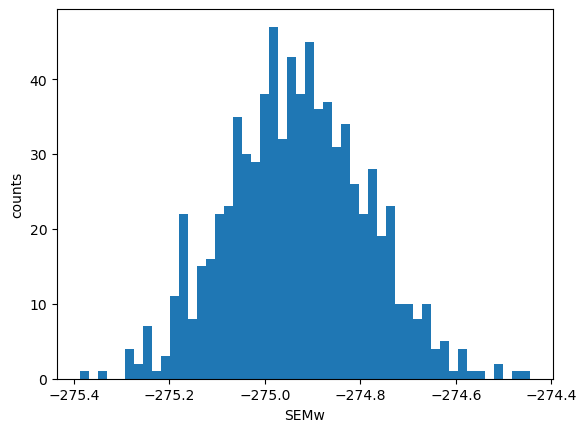

In [19]:
plt.hist(eofl, 50)
plt.xlabel('SEMw')
plt.ylabel('counts')
#plt.xlim([eofl_mean - 3*eofl_std, eofl_mean + 3*eofl_std])
plt.show()

In [20]:
# display the auxiliary reference data
dfx, fmtx = mrx.exptl_as_DF(exptl, os.sep.join(['refdata', 'label_meanings.tsv']))
display(dfx.style.format(fmtx))

,Label,Name,EoF,unc,unit,source
0,dioxolane,"1,3-dioxacyclopentane",-275.000,0.700,kJ/mol,Local
1,n2,dinitrogen,0.000,-999.000,kJ/mol,ATcT
2,hcn,hydrogen cyanide,129.665,0.044,kJ/mol,ATcT
3,no,nitric oxide,90.631,0.033,kJ/mol,ATcT
4,nh3,ammonia,-38.565,0.015,kJ/mol,ATcT
5,hcl,hydrogen chloride,-91.989,0.003,kJ/mol,ATcT
6,ch3cl,chloromethane,-74.310,0.125,kJ/mol,ATcT
7,hocl,hypochlorous acid,-73.866,0.013,kJ/mol,ATcT
8,h2,dihydrogen,0.000,-999.000,kJ/mol,ATcT
9,ch4,methane,-66.557,0.025,kJ/mol,ATcT
